# Deciding eastern bounday of JDF Lagrangian simmulation
##### Based in this file on Ben's OceanParcels Recipe - more sucess with particles moving with tides (not sure what went wrong in my other file as they are still using hourly) and how i figured out how to make vertical velocity important

In [1]:
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation
from datetime import datetime, timedelta
# from dateutil.parser import parse
from IPython.display import HTML
from salishsea_tools import nc_tools, places

from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, AdvectionRK4_3D
#Field,VectorField, AdvectionRK4,


%matplotlib inline

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2919/libparcels_random_24d82caa-ced0-44e4-971a-8e1a363c8b14.so


### Functions

In [2]:
def fieldset_from_nemo(daterange, coords, flat=True):
    """Generate a fieldset from a hourly SalishSeaCast forcing fields
    over daterange.
    """

    # Generate sequential list of forcing file prefixes
    prefixes = [
        nc_tools.get_hindcast_prefix(daterange[0] + timedelta(days=d))
        for d in range(np.diff(daterange)[0].days + 1)
    ]

    # Predefine fieldset argument dictionaries
    filenames, variables, dimensions = {}, {}, {}

    # Define dict fields for each variable
    for var, name in zip(['U', 'V', 'W'], ['vozocrtx', 'vomecrty', 'vovecrtz']):
        
        # Exclude vertical velocity if 2D
        if flat:
            if var == 'W': break

        # Dict of filenames containing the coordinate and forcing variables
        datafiles = [prefix + f'_grid_{var}.nc' for prefix in prefixes]
        filenames[var] = {'lon': coords, 'lat': coords, 'data': datafiles}

        # NEMO variable name
        variables[var] = name

        # Dict of NEMO coordinate names (f-points)
        dimensions[var] = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
        
        # Add depth fields if 3D (f-points are on W grid)
        if not flat:
            filenames[var]['depth'] = prefixes[0] + '_grid_W.nc'
            dimensions[var]['depth'] = 'depthw'

    # Load NEMO forcing into fieldset
    field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)# field_chunksize='auto')
    
    return field_set

In [3]:
def DeleteParticle(particle, fieldset, time):
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

### Simmulations

In [4]:
# Paths and filenames
paths = {
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    #'results': '/data/bmoorema/results/parcels/sandbox',
    'results': './results',
}

# Load coords and mask files and extract grid variables
coords, mask = [xr.open_dataset(paths[key], decode_times=False) for key in ('coords', 'mask')]
gridlon, gridlat = [coords[key][0, ...].values for key in ('glamt', 'gphit')]
tmask = mask.tmask[0, 0, ...].values

In [16]:
# Define release parameters
location = 'Central SJDF'
n = 10   # number of particles
r = 50   # radius of particle cloud [m]

# Start time, duration and timestep
start = datetime(2019, 3, 1, 12, 30, 0)
duration = timedelta(days=15)
dt = -90#timedelta(seconds=90)

# Create Gaussian distribution around release point
mean, cov = [0, 0], [[r**2, 0], [0, r**2]]
x_offset, y_offset = np.random.multivariate_normal(mean, cov, n).T
lon, lat = places.PLACES[location]['lon lat']
lons = lon + x_offset / 111000 / np.cos(np.deg2rad(lat))
lats = lat + y_offset / 111000

# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 125.
zvals = dmin + np.random.random_sample(n)*(dmax-dmin)

# Forcing daterange (I add 1-day buffers)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

In [17]:
# Set output file name.  Maybe change for each run
fn = f'JDFeastBDY' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['results'], fn)
print(outfile)

./results/JDFeastBDY20190301_1n_20190316_1n.nc


In [18]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'], flat=False) #flat=False forces it to care about bathymetry

In [19]:
# Execute NEMO-only, 3D run, release at 5m
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lons, lat=lats, depth=zvals, time=np.repeat(start, n))

pset.execute(
    pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
    output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-2919/d3bebecd4be1059eb3ff136d0b38c81a_0.so
INFO: Temporary output files are stored in ./results/out-SWSBEKMI.
INFO: You can use "parcels_convert_npydir_to_netcdf ./results/out-SWSBEKMI" to convert these to a NetCDF file during the run.
100% (1296000.0 of 1296000.0) |##########| Elapsed Time: 0:01:23 Time:  0:01:23


In [20]:
# Had this cell earlier before but seem to need to run it after simulationto get the outputfiles 
# from the temp directory into my final outfile
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [21]:
data = xr.open_dataset(outfile)

Text(0.5, 0, 'Longitude')

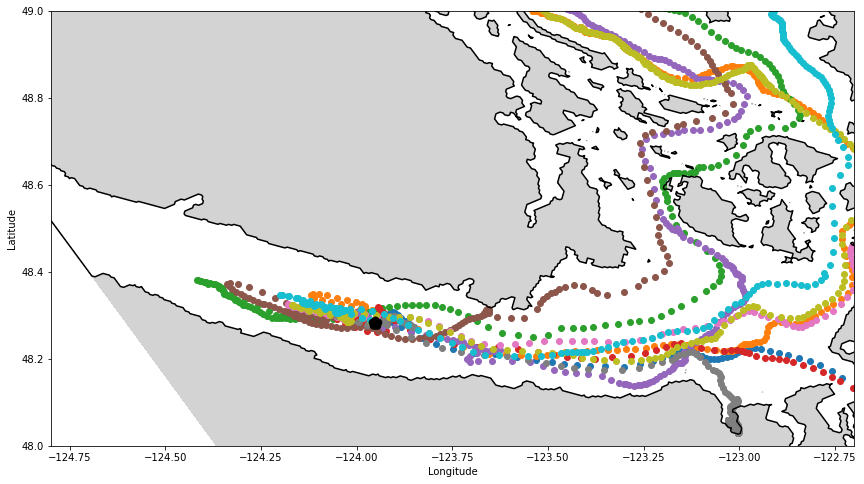

In [22]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
for traj in range(n):
    s = ax.scatter(data.lon[traj, nmin:nmax], data.lat[traj, nmin:nmax])
ax.scatter(lon,lat,c='k', marker='*', linewidths=8)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

Text(0.5, 0, 'Longitude')

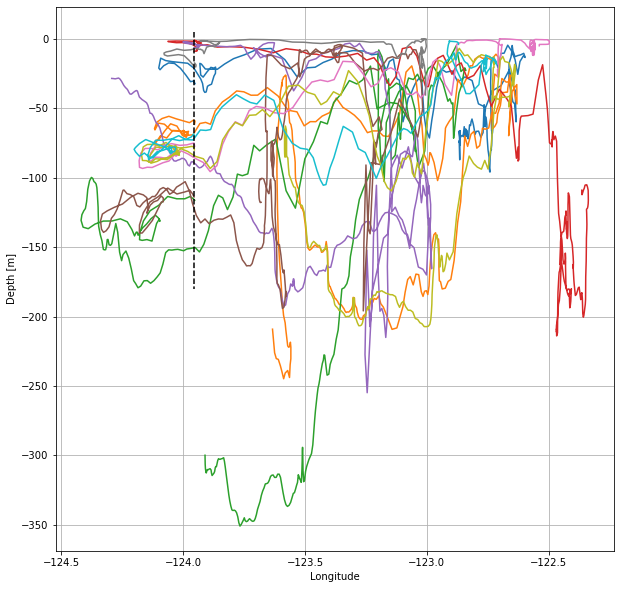

In [23]:
nmax = -1
fig, ax = plt.subplots(figsize=(10, 10))
for traj in range(n):
    s = ax.plot(data.lon[traj, nmin:nmax], -data.z[traj, nmin:nmax])
ax.grid()
ax.plot([lon,lon],[5,-180],'k--')
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')

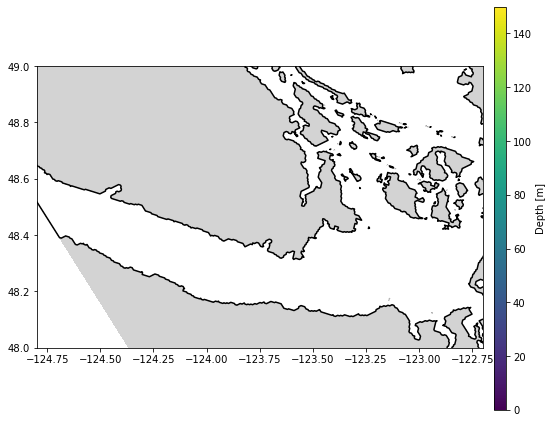

In [24]:
# Make initial figure
fig, ax = plt.subplots(figsize=(8, 8))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=150, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
    tstamp = data.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l.set_offsets(np.vstack([data.lon[:, hour], data.lat[:, hour]]).T)
    l.set_array(data.z[:, hour])
    return l, t,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=np.shape(data.time)[1]-1, interval=100, blit=True)

In [25]:
np.shape(data.time)[1]-1

360

In [26]:
# Render animation
HTML(anim.to_html5_video())